In [1]:
import sys
import os
import time
import warnings
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from cycler import cycler
from matplotlib import ticker
from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow, BallWindow
from structure_factor.hyperuniformity import bin_data, hyperuniformity_class
from structure_factor.data import load_data
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf
from structure_factor.tapers import multi_sinetaper_grid
from structure_factor.utils import meshgrid_to_column_matrix
from structure_factor.tapered_estimators import allowed_k_scattering_intensity, scattering_intensity, tapered_estimator_debiased_direct

import massPy as mp
from utils import get_defect_list, get_defect_arr_from_frame, get_frame_number, do_chi2_fit
from AnalyseDefects import AnalyseDefects

## Set plotting style and print options
plt.style.use('sg_article')
np.set_printoptions(precision = 5, suppress=1e-10)

In [4]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 0, LX = LL, Nframes = 400)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = 3, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

def get_pair_corr_function(ar, ar_path, ball_window, frame_interval = None, method = "fv", \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40)):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    # Extract LX, LY from first frame
    frame = ar._read_frame(frame_interval[0])
    LX, LY = frame.LX, frame.LY

    # Get defect list
    defect_list = get_defect_list(ar, frame_interval[0], Nframes, archive_path=ar_path)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    return rad_arr, pcf_arr

def get_pair_corr_from_defect_list(defect_list, ball_window, frame_idx_interval = None, method = "fv", \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40), save=False, save_dir=None, save_suffix=None):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = len(defect_list) if frame_idx_interval is None else frame_idx_interval[1] - frame_idx_interval[0]
    frame_interval = [0, Nframes - 1] if frame_idx_interval is None else frame_idx_interval

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[frame])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    if save:
        if save_dir is not None:
            if not os.path.isdir(save_dir):
                os.makedirs(save_dir)
        np.save(save_dir + f'rad_arr{save_suffix}.npy', rad_arr)
        np.save(save_dir + f'pcf_arr{save_suffix}.npy', pcf_arr)

    return rad_arr, pcf_arr

def calc_pair_corr_function(defect_arr, ball_window, method = 'fv', \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40),):
    """
    Calculate pair correlation function for a single frame
    """

    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, ball_window)

    # Calculate pair correlation function
    pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)


    return pcf_estimated

def plot_pair_corr_function(pcf_estimated = None, rad_arr = None, pcf_arr = None, frame = None, plot_norm = False):
    """
    Plot pair correlation function
    """
    if isinstance(pcf_estimated, pd.DataFrame):
        r = pcf_estimated.r
        g = pcf_estimated.pcf
    else:
        try:
            r = rad_arr
            g = pcf_arr
        except:
            raise ValueError("No pair correlation function data provided")

    if plot_norm:
        g = np.abs(g)

    title = "Pair correlation function" if frame is None else "Pair correlation function, frame = {}".format(frame)

    fig, ax = plt.subplots()
    ax.plot(r, g, '-')
    ax.set_xlabel(rf"$r$ (radius of observation window)")
    ax.set_ylabel(rf"$g(r)$")
    ax.set_title(title)
    return fig, ax

def calc_structure_factor(defect_arr, box_window, kmax, debiased = True, direct = True, nbins = 50):
    """
    Calculate structure factor for a single frame
    """
    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, box_window)
    sf = StructureFactor(point_pattern)
    k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)

    # Bin data
    knorms = np.linalg.norm(k, axis=1)
    kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

    return k, sf_estimated, kbins, smeans, sstds

def plot_structure_factor(kbins, smeans, sstds, k = None, plot_scaling=False, LX = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    fig, ax = plt.subplots()
    
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    if plot_scaling:
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')

    ax.set_xscale('log')
    ax.set_yscale('log')
 #   ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),3))   
    
 #   ax.set_ylim([sf_min/4, sf_max + 3])
  #  ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'Norm of wavenumber ($k$)')
    ax.set_ylabel(r'Time av. structure factor')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    #    ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])

    return fig, ax

def get_structure_factor(ar, box_window, LX = None, frame_interval = None, kmax = 1, debiased = True, direct = True, nbins = 50,):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    if LX is None:
        # Extract LX, LY from first frame
        frame = ar._read_frame(frame_interval[0])
        LX, LY = frame.LX, frame.LY
    else:
        LY = LX

    # Initialize structure factor
    sf_arr = None

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        if defect_positions is None:
            continue

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)
        t1 = time.time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)

            sf = StructureFactor(point_pattern)
            k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)
            
        t2 = time.time()
        print("Time for structure factor: {}".format(t2 - t1))

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method='fv', \
                                 Kest=dict(rmax=10), fv=dict(method="b", spar=0.2))
        t3 = time.time()
        print("Time for pair correlation function: {}".format(t3 - t2))

        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if sf_arr is None:
            kbins_arr = kbins.astype('float')
            sf_arr = np.zeros([Nframes, len(kbins_arr), 2]) * np.nan
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    return kbins_arr, sf_arr



In [19]:
LL = 512
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_dir_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_dir_list, output_path=output_path)

In [24]:
ad.act_list[0][12]

0.0245

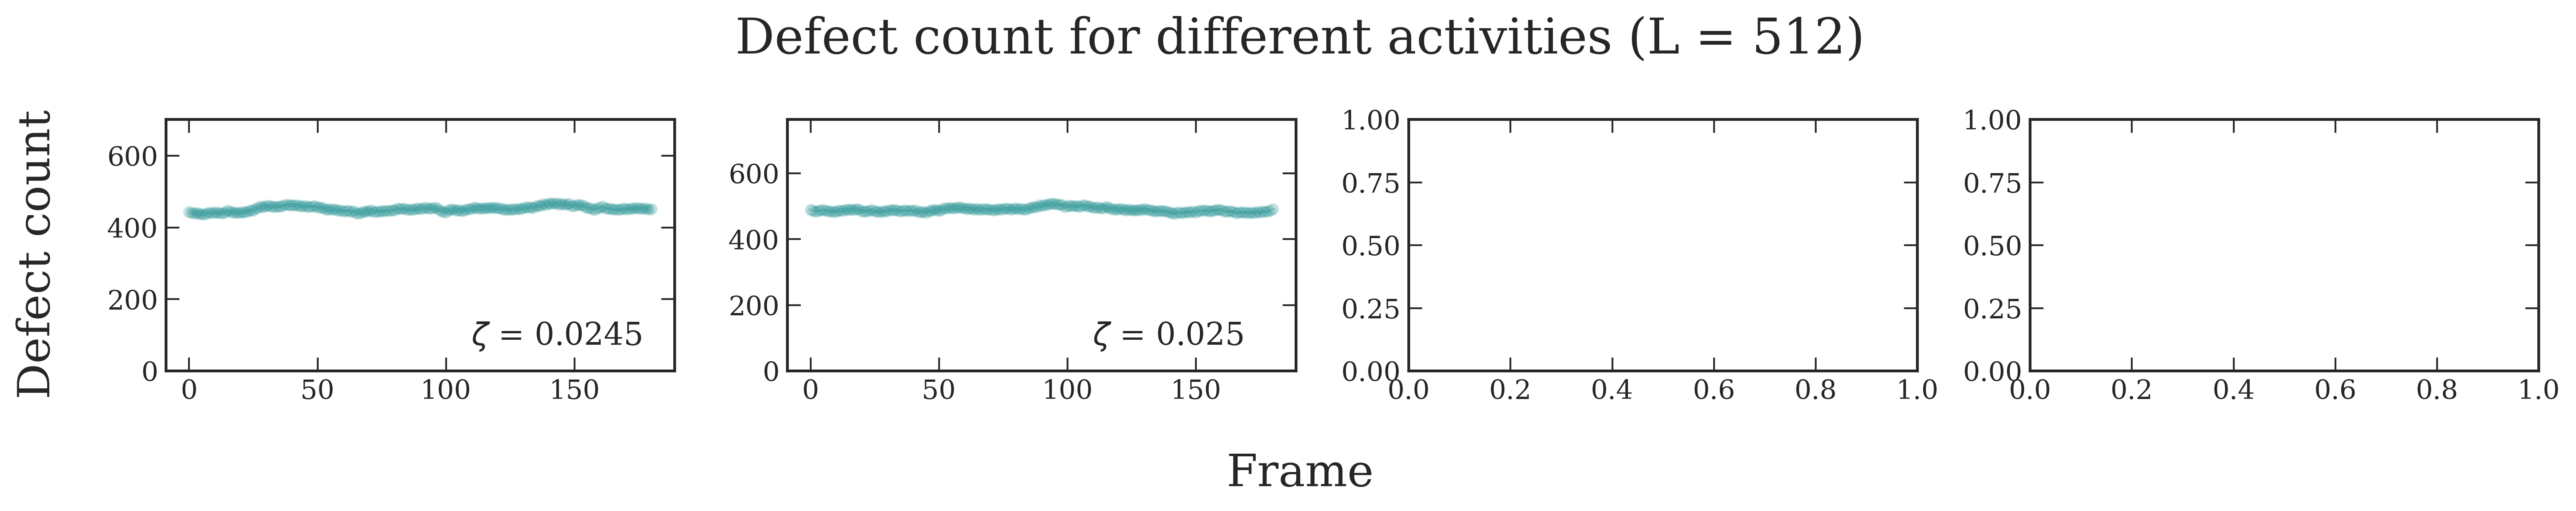

(<Figure size 6720x1260 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

In [43]:
ad.plot_defects_per_activity(0,act_idx_bounds=[12,14])

In [39]:
def extract_pcf_results(data_path, Nframes = 181, Nexp = 10, save = False):
    """
    Analyse the defects for all the input folders
    """

    act_list = [float(os.listdir(data_path)[i].split('_')[-1]) for i in range(len(os.listdir(data_path)))]
    act_dir_list = [os.path.join(data_path, os.listdir(data_path)[i]) for i in range(len(os.listdir(data_path)))]

    arrays_init = False
    
    for i, (act, act_dir) in enumerate(zip(act_list, act_dir_list)):

        exp_list = []
        exp_dir_list = []

        for file in os.listdir(act_dir):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir, file))

        # sort the activity list and the activity directory list
        exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

        for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
            if not arrays_init:
                try:
                    rad_arr = np.load(os.path.join(exp_dir, 'rad_arr.npy'))
                    pcf_vals = np.load(os.path.join(exp_dir, 'pcf_arr.npy'))

                    pcf_arr = np.nan * np.zeros((pcf_vals.shape[0], pcf_vals.shape[-1], len(act_list), len(exp_list)))
                    pcf_arr[:, :, i, j] = pcf_vals
                    arrays_init = True
                except:
                    continue
            else:
                try:
                    pcf_vals = np.load(os.path.join(exp_dir, 'pcf_arr.npy'))
                    pcf_arr[:, :, i, j] = pcf_vals

                except: 
                    continue
    if arrays_init:
        return rad_arr, pcf_arr
    else:
        return None, None

In [40]:
data_path = 'X:\\pcf512'

act_list = [float(os.listdir(data_path)[i].split('_')[-1]) for i in range(len(os.listdir(data_path)))]
act_dir_list = [os.path.join(data_path, os.listdir(data_path)[i]) for i in range(len(os.listdir(data_path)))]
act_list, act_dir_list
rad_arr, pcf_arr = extract_pcf_results(data_path, Nframes = 181, Nexp = 10, save = False)

In [44]:
pcf_arr.shape

(181, 513, 2, 10)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_7944\2165445895.py:2: RuntimeWarning: Mean of empty slice
  pcf_arr_av = np.nanmean(pcf_arr, axis = (0,-1)) - 1
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


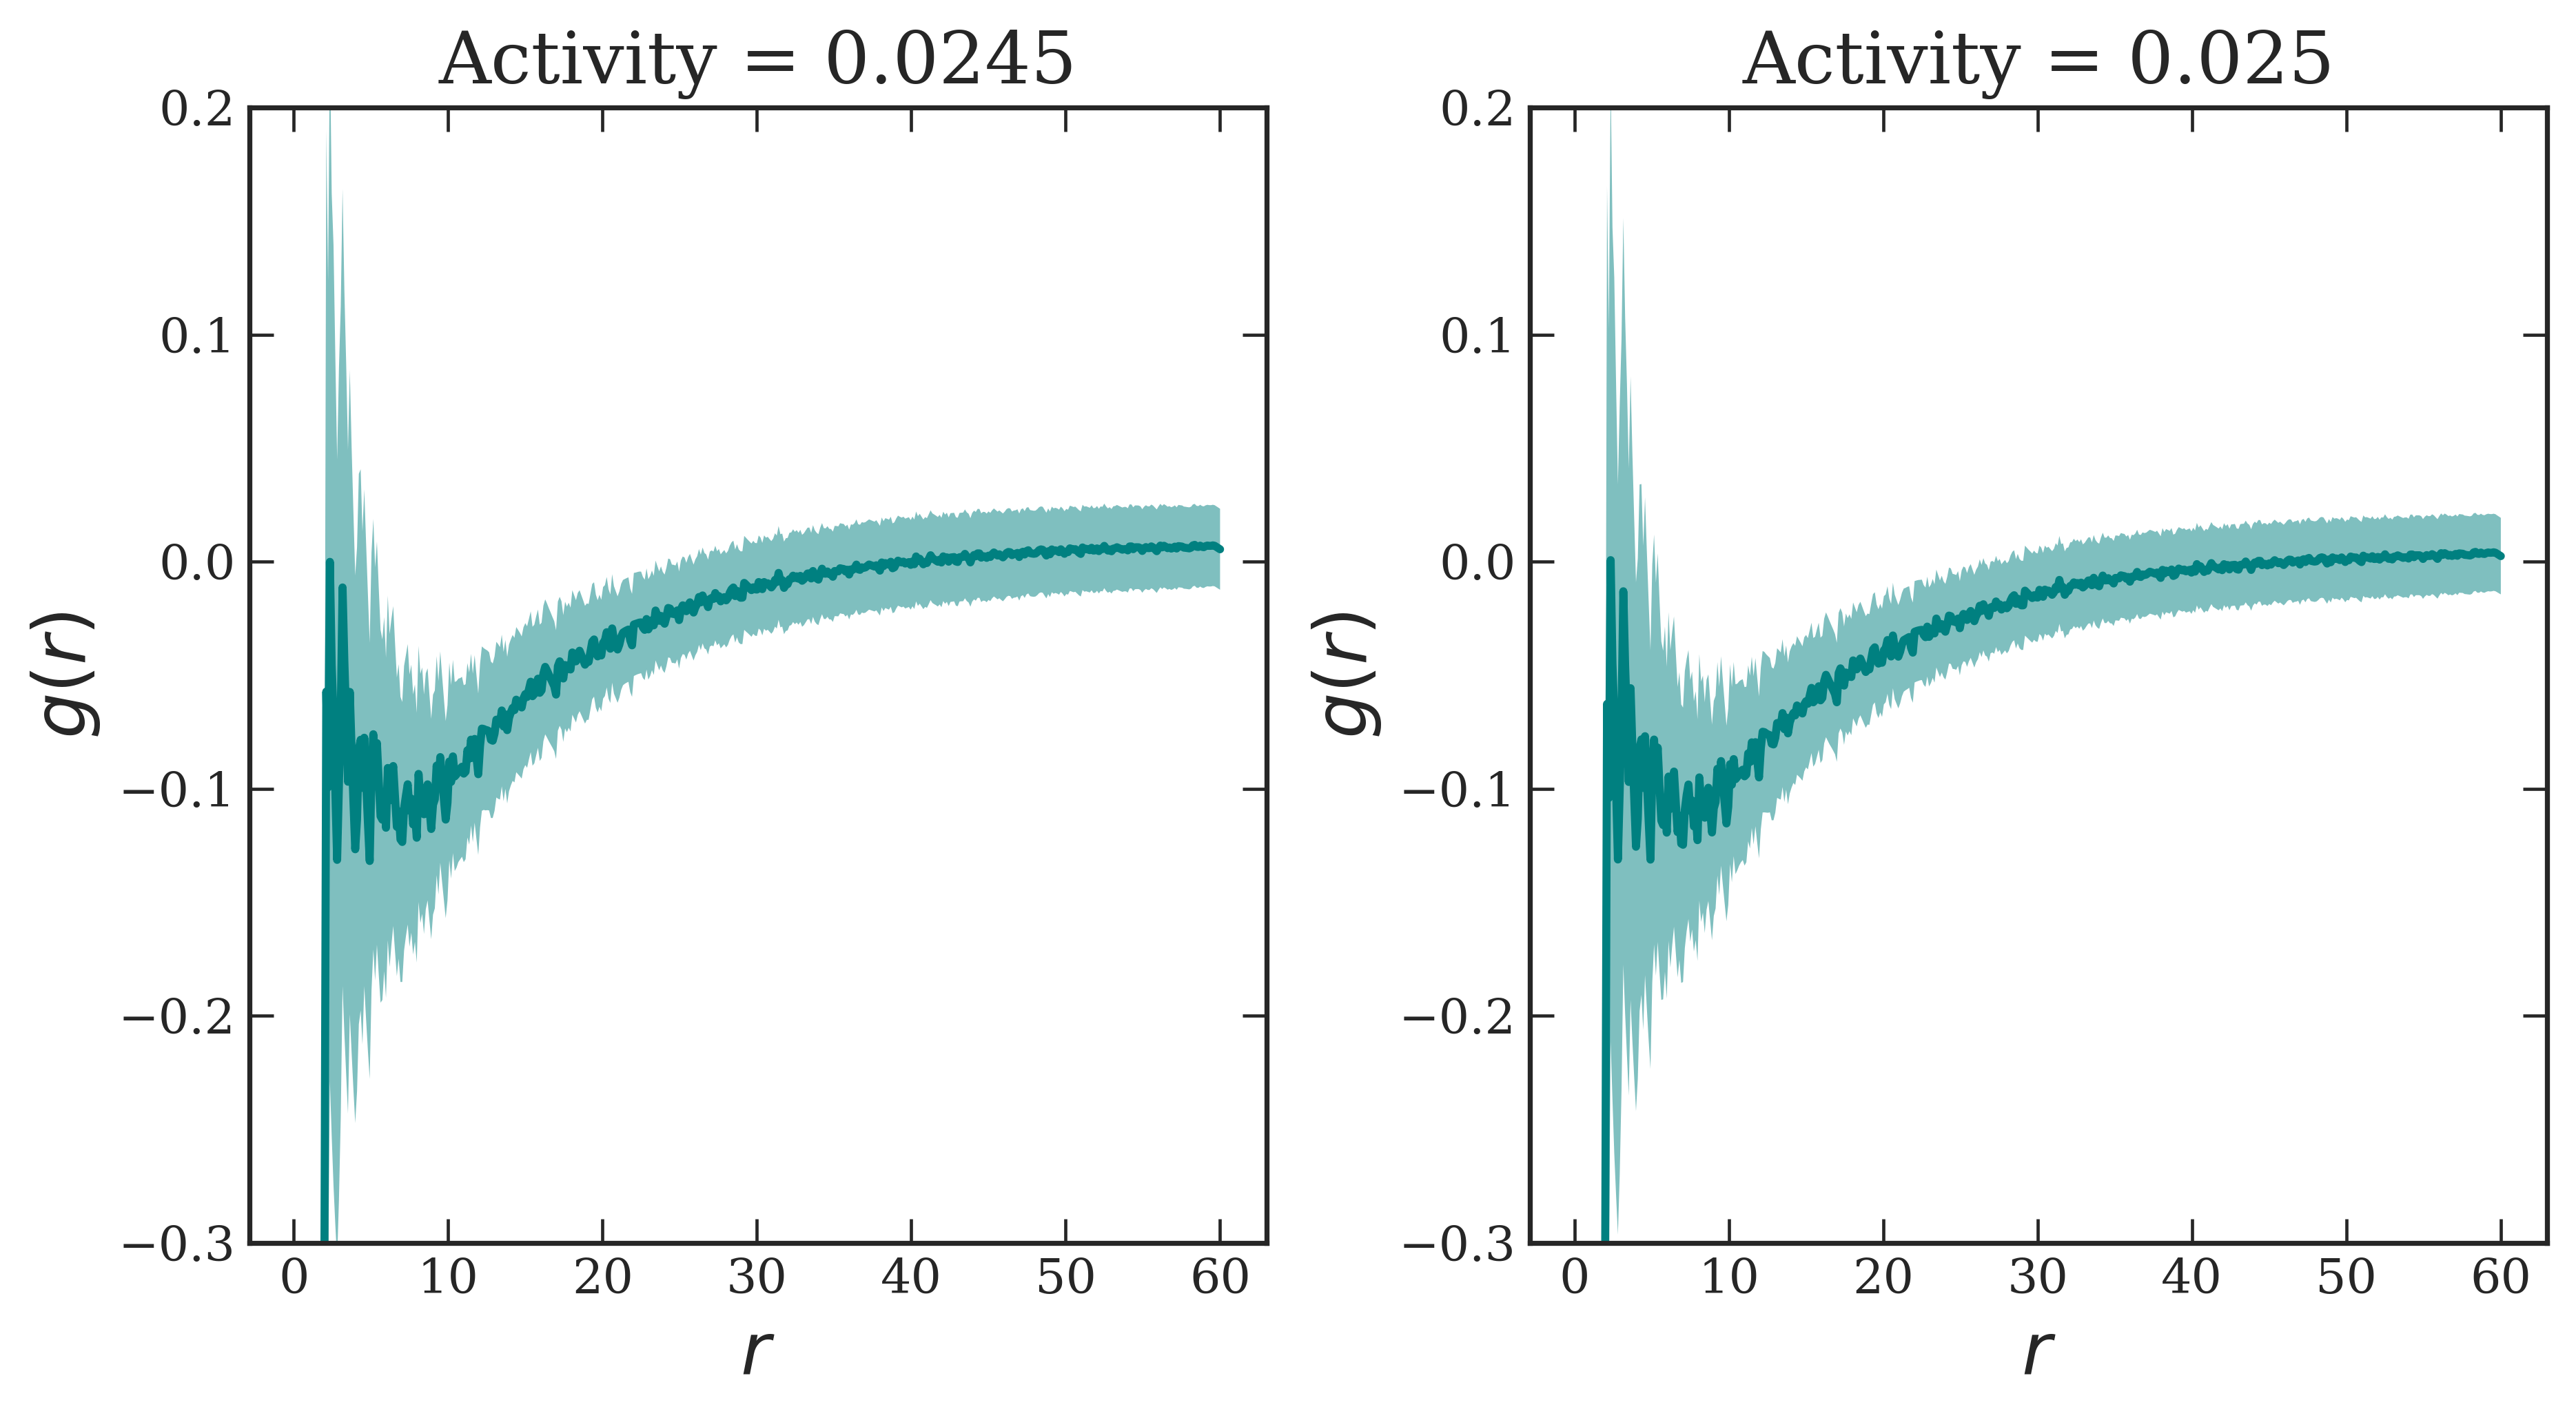

In [47]:
fig, ax = plt.subplots(ncols = len(act_list), figsize=(9,5))
pcf_arr_av = np.nanmean(pcf_arr, axis = (0,-1)) - 1
pcf_arr_av_std = np.nanstd(pcf_arr, axis = (0,-1), ddof=1) 

for i in range(len(act_list)):
    ax[i].plot(rad_arr, pcf_arr_av[:, i])
    ax[i].fill_between(rad_arr, pcf_arr_av[:, i] - pcf_arr_av_std[:, i], pcf_arr_av[:, i] + pcf_arr_av_std[:, i], alpha = 0.5)
    ax[i].set_title(f'Activity = {act_list[i]}')
    ax[i].set_xlabel(r'$r$')
    ax[i].set_ylabel(r'$g(r)$')
    ax[i].set_ylim([-0.3, .2])

In [42]:
act_idx = 1
act = act_list[act_idx]
Nexp = 10
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20, 15))
ax = ax.flatten()
for i in range(Nexp):
    
    ax[i].errorbar(rad_arr, np.nanmean(pcf_arr[:, :, act_idx,i], axis=0) - 1,\
        np.nanstd(pcf_arr[:, :, act_idx,i], axis=0, ddof=1), label=f'Exp: {i}', alpha=.4)
    ax[i].legend()
    ax[i].set(ylim=[-.1, .35])
    ax[i].grid(True)


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_7944\2674330235.py:8: RuntimeWarning: Mean of empty slice
  ax[i].errorbar(rad_arr, np.abs(np.nanmean(pcf_arr[:, :, act_idx,i], axis=0) - 1),\
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [6]:
fig, ax = plt.subplots()

#  ax.plot(rad_arr, np.abs(np.nanmean(pcf_arr, axis=0) - 1), label=f'{act}')
ax.errorbar(rad_arr, np.abs(np.nanmean(pcf_arr, axis=0) - 1),\
        np.abs(np.nanstd(pcf_arr, axis=0)), label=f'{act}', alpha=.4)

ax.legend()
ax.set(ylim=[-.05, .25])
ax.grid(True)

['analysis_zeta_0.0245', 'analysis_zeta_0.025']

In [ ]:
LX, LY = 512, 512
data_path = 'X:\\pcf512'


### TEST TEST TEST
save_path = 'data\\nematic_analysis1024_LL0.05\\pair_corr_test\\'
save = True
load = True
data_dirs = os.listdir(path)

cluster_files = [f for f in data_dirs if f.startswith('na1024_a') and f.endswith('_cl')]
activity_list = [float('0.0' + f.split('_')[1][1:-2])  for f in cluster_files]
data_dirs = [os.path.join(path, d) for d in cluster_files]

# Sort data_dirs by activity
#data_dirs = [x for _, x in sorted(zip(activity_list, data_dirs))]
#activity_list.sort()

Ncl22 = 1
Ncl24 = 2
Ncl255 = 3

#ar = mp.archive.loadarchive(data_dirs[N])
activity_list, data_dirs 